In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
try:
    import xgboost as xgb
except ImportError:
    xgb = None
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load and clean data and also clean the messages
def load_and_clean_data():
    """
    Task 1: Data Loading and Cleaning
    """
    print("=" * 60)
    print("TASK 1: DATA LOADING AND CLEANING")
    print("=" * 60)
    
    df = pd.read_excel("test.xlsx")
    print(f"Original dataset shape: {df.shape}")
    
    df = df.dropna(subset=['body', 'date', 'from'])
    df = df[df['body'].str.strip() != '']
    print(f"After removing missing data: {df.shape}")
    
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])  # type: ignore
    print(f"After date conversion: {df.shape}")
    
    df = df.drop_duplicates(subset=['from', 'date', 'body'])
    print(f"After removing duplicates: {df.shape}")
    
    #clean messages
    def clean_message(text):
        text = str(text).lower()
        text = re.sub(r'[\r\n\t]+', ' ', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    df['cleaned_message'] = df['body'].apply(clean_message)
    df['word_count'] = df['cleaned_message'].str.split().str.len()
    df['char_count'] = df['cleaned_message'].str.len()
    
    print("Data cleaning completed!")
    return df

In [3]:
#labelling
def perform_sentiment_labeling(df):
    """
    Task 1: Sentiment Labeling
    """
    print("\n" + "=" * 60)
    print("TASK 1: SENTIMENT LABELING")
    print("=" * 60)
    
  #  sentiment intensity analyzer is used to get the sentiment score
    analyzer = SentimentIntensityAnalyzer()
    
    def get_sentiment(text):
        if not isinstance(text, str):
            return "Neutral"
        
        score = analyzer.polarity_scores(text)
        compound = score['compound']
        
        if compound >= 0.05:
            return 'Positive'
        elif compound <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    
    
    df['sentiment_label'] = df['cleaned_message'].apply(get_sentiment)
    
    #postive ,negetive and neutral points giving on the basis of compound score
    sentiment_score_map = {
        'Positive': 1,
        'Neutral': 0,
        'Negative': -1
    }
    df['sentiment_score'] = df['sentiment_label'].map(sentiment_score_map)
    
    print("Sentiment labeling completed!")
    print(f"Sentiment distribution:\n{df['sentiment_label'].value_counts()}")
    
    return df

In [4]:
#EDA-data analysis and visualization
def exploratory_data_analysis(df):
    """
    Task 2: Exploratory Data Analysis (EDA)
    """
    print("\n" + "=" * 60)
    print("TASK 2: EXPLORATORY DATA ANALYSIS")
    print("=" * 60)
    
    
    sns.set(style="whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6)
    
    print("Dataset Information:")
    print(df.info())
    print(f"\nMissing Values:\n{df.isnull().sum()}")
    
    sentiment_counts = df['sentiment_label'].value_counts()
    print(f"\nSentiment Distribution:\n{sentiment_counts}")
    #plotting the graph for sentiment distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    #sentiment label distribution is plotted
    sns.countplot(data=df, x='sentiment_label', ax=axes[0,0], palette='Set2')
    axes[0,0].set_title("Sentiment Label Distribution")
    axes[0,0].set_xlabel("Sentiment")
    axes[0,0].set_ylabel("Number of Messages")
    
    sentiment_counts.plot.pie(autopct='%1.1f%%', startangle=90, 
                             colors=sns.color_palette("Set2"), ax=axes[0,1])
    axes[0,1].set_title("Sentiment Distribution")
    axes[0,1].set_ylabel("")
    
    #monthly sentiment trend is plotted
    df['month'] = df['date'].dt.to_period('M')
    monthly_trend = df.groupby(['month', 'sentiment_label']).size().unstack(fill_value=0)
    monthly_trend.plot(marker='o', ax=axes[1,0])
    axes[1,0].set_title("Monthly Sentiment Trend")
    axes[1,0].set_xlabel("Month")
    axes[1,0].set_ylabel("Message Count")
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True)
    axes[1,0].legend(title="Sentiment")
    
    sns.histplot(df['word_count'], bins=30, kde=True, color='purple', ax=axes[1,1])
    axes[1,1].set_title("Distribution of Word Counts in Messages")
    axes[1,1].set_xlabel("Word Count")
    axes[1,1].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.savefig('visualization/eda_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
#top 10 employees by message count is plotted
    top_senders = df['from'].value_counts().head(10)
    plt.figure(figsize=(12, 8))
    sns.barplot(y=top_senders.index, x=top_senders.values, palette="coolwarm")
    plt.title("Top 10 Employees by Message Count")
    plt.xlabel("Messages Sent")
    plt.ylabel("Employee")
    plt.tight_layout()
    plt.savefig('visualization/top_employees.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("EDA completed and visualizations saved!")
    return df

In [5]:
#calculate the employee scores
def calculate_employee_scores(df):
    """
    Task 3: Employee Score Calculation
    """
    print("\n" + "=" * 60)
    print("TASK 3: EMPLOYEE SCORE CALCULATION")
    print("=" * 60)
    
    #monthly sentiment score of the employee is calculated
    monthly_scores = df.groupby(['from', df['date'].dt.to_period('M')])['sentiment_score'].sum().reset_index()
    monthly_scores.columns = ['employee', 'month', 'monthly_sentiment_score']
    monthly_scores = monthly_scores.sort_values(['employee', 'month'])
    
    print(f"Monthly scores calculated for {len(monthly_scores)} employee-month combinations")
    print(f"Score range: {monthly_scores['monthly_sentiment_score'].min()} to {monthly_scores['monthly_sentiment_score'].max()}")
    #each monthly sentiment score of the employee is saved in the excel file
    monthly_scores.to_excel("D:\\employee-sentiment-analysis\\monthly_employee_sentiment_scores.xlsx", index=False)
    print("Monthly scores saved to 'monthly_employee_sentiment_scores.xlsx'")
    
    return monthly_scores

In [6]:
#as per employee monthly sentiment score, the top 3 positive and negative employees are ranked
def employee_ranking(monthly_scores):
    """
    Task 4: Employee Ranking
    """
    print("\n" + "=" * 60)
    print("TASK 4: EMPLOYEE RANKING")
    print("=" * 60)
    
    #top positive score employees are ranked
    top_positive = (
        monthly_scores
        .sort_values(['month', 'monthly_sentiment_score', 'employee'], ascending=[True, False, True])
        .groupby('month')
        .head(3)
        .reset_index(drop=True)
    )
    top_positive['rank_type'] = 'Top Positive'
    #top negative score employees are ranked
    top_negative = (
        monthly_scores
        .sort_values(['month', 'monthly_sentiment_score', 'employee'], ascending=[True, True, True])
        .groupby('month')
        .head(3)
        .reset_index(drop=True)
    )
    top_negative['rank_type'] = 'Top Negative'
    
    
    employee_ranking = pd.concat([top_positive, top_negative], ignore_index=True)
    employee_ranking = employee_ranking.sort_values(['month', 'rank_type', 'monthly_sentiment_score'], 
                                                   ascending=[True, True, False])
    
    print("Top 3 Positive and Negative Employees per Month:")
    print(employee_ranking.head(20))
    
    #employee rankings are saved in the excel file
    employee_ranking.to_excel("D:\\employee-sentiment-analysis\\employee_monthly_ranking.xlsx", index=False)
    print("Employee rankings saved to 'employee_monthly_ranking.xlsx'")
    
    return employee_ranking

In [7]:
#flight risk identification
def flight_risk_identification(df):
    """
    Task 5: Flight Risk Identification
    CORRECTED: According to project requirements - 4+ negative messages in a given month
    """
    print("\n" + "=" * 60)
    print("TASK 5: FLIGHT RISK IDENTIFICATION")
    print("=" * 60)
    #sentiment label negetive employees are identified
    neg_df = df[df['sentiment_label'] == 'Negative'].copy()
    neg_df['date'] = pd.to_datetime(neg_df['date'], errors='coerce')
    
    monthly_negative_counts = neg_df.groupby(['from', neg_df['date'].dt.to_period('M')]).size().reset_index(name='negative_count')
    #flight risk employees with negetive count are identified
    flight_risk_employees = monthly_negative_counts[monthly_negative_counts['negative_count'] >= 4]['from'].unique()
    flight_risks = set(flight_risk_employees)
    
    print(f"Found {len(flight_risks)} employees flagged as flight risks")
    print("Flight Risk Employees:")
    for emp in flight_risks:
        print(f"- {emp}")
    
    #flight risk employees are saved in the excel file
    flight_risk_df = pd.DataFrame({'employee': list(flight_risks)})
    flight_risk_df.to_excel("D:\\employee-sentiment-analysis\\flight_risk_employees.xlsx", index=False)
    print("Flight risk list saved to 'flight_risk_employees.xlsx'")
    
    return flight_risk_df

In [8]:
#predictive modeling
def predictive_modeling(df):
    """
    Task 6: Enhanced Predictive Modeling with Advanced Features and Models
    """
    print("\n" + "=" * 60)
    print("TASK 6: ENHANCED PREDICTIVE MODELING")
    print("=" * 60)
    
    
    print("Creating enhanced features...")
    
    #features are created for the predictive model
    monthly_features = df.groupby(['from', df['date'].dt.to_period('M')]).agg({
        'cleaned_message': 'count',
        'word_count': ['sum', 'mean', 'std'],
        'char_count': ['sum', 'mean'],
        'sentiment_score': ['sum', 'mean', 'std'],
        'sentiment_label': lambda x: (x == 'Positive').sum(),
        'body': lambda x: (x == 'Negative').sum()
    }).reset_index()
    
   #monthly features are created
    monthly_features.columns = ['employee', 'month', 'message_count', 'total_word_count', 
                               'avg_word_count', 'word_count_std', 'total_char_count', 
                               'avg_char_count', 'sentiment_score_sum', 'sentiment_score_mean', 
                               'sentiment_score_std', 'positive_count', 'negative_count']
    
   #monthly feature calculationg formulas
    monthly_features['sentiment_ratio'] = monthly_features['sentiment_score_sum'] / monthly_features['message_count']
    monthly_features['positive_ratio'] = monthly_features['positive_count'] / monthly_features['message_count']
    monthly_features['negative_ratio'] = monthly_features['negative_count'] / monthly_features['message_count']
    monthly_features['word_per_message'] = monthly_features['total_word_count'] / monthly_features['message_count']
    monthly_features['char_per_word'] = monthly_features['total_char_count'] / monthly_features['total_word_count']
    
  
    monthly_features['month_num'] = monthly_features['month'].astype(str).str[:4].astype(int) * 12 + \
                                   monthly_features['month'].astype(str).str[5:7].astype(int)
    
   #employee stats are created
    employee_stats = df.groupby('from').agg({
        'sentiment_score': ['mean', 'std'],
        'word_count': ['mean', 'std'],
        'cleaned_message': 'count'
    }).reset_index()
    employee_stats.columns = ['employee', 'emp_sentiment_mean', 'emp_sentiment_std', 
                             'emp_word_mean', 'emp_word_std', 'emp_total_messages']
    
    monthly_features = monthly_features.merge(employee_stats, on='employee', how='left')



    #monthly feature on sentiment volatility, word volatility and message intensity are created
    monthly_features['sentiment_volatility'] = monthly_features['sentiment_score_std'] / (monthly_features['emp_sentiment_std'] + 1e-6)
    monthly_features['word_volatility'] = monthly_features['word_count_std'] / (monthly_features['emp_word_std'] + 1e-6)
    monthly_features['message_intensity'] = monthly_features['message_count'] / monthly_features['emp_total_messages']
    
    #if there any error in the data, it is dropped
    monthly_features.dropna(inplace=True)
    
    print(f"Enhanced feature dataset shape: {monthly_features.shape}")

   #feature columns are created
    feature_columns = ['message_count', 'total_word_count', 'avg_word_count', 'word_count_std',
                      'total_char_count', 'avg_char_count', 'sentiment_score_sum', 'sentiment_score_mean', 
                      'sentiment_score_std', 'positive_count', 'negative_count', 'sentiment_ratio',
                      'positive_ratio', 'negative_ratio', 'word_per_message', 'char_per_word',
                      'month_num', 'emp_sentiment_mean', 'emp_sentiment_std', 'emp_word_mean', 
                      'emp_word_std', 'emp_total_messages', 'sentiment_volatility', 'word_volatility', 
                      'message_intensity']
    

    #now plotting the graph for the feature columns
    X = monthly_features[feature_columns]
    y = monthly_features['sentiment_score_sum']  # Target: monthly sentiment score
    
    print(f"Number of features: {len(feature_columns)}")
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    selector = SelectKBest(score_func=f_regression, k=15)
    X_selected = selector.fit_transform(X_scaled, y)
    selected_features = X_scaled.columns[selector.get_support()].tolist()
    X_selected = pd.DataFrame(X_selected, columns=selected_features)  # type: ignore
    
    print(f"Selected top {len(selected_features)} features: {selected_features}")
    
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    #linear regression, ridge regression, lasso regression, random forest, gradient boosting and svr are used for the predictive model
    #compare the performance of the models and select the best model
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'SVR': SVR(kernel='rbf', C=1.0, gamma='scale')
    }
    
   
    if xgb is not None:
        models['XGBoost'] = xgb.XGBRegressor(n_estimators=100, random_state=42)
    
    results = {}
    best_model = None
    best_r2 = -float('inf')
    best_name = ""
    
    #Training and evaluating the models and selecting the best model
    print("\nTraining and evaluating models...")
    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_test)
            
            #Calculating the R^2 score and RMSE for the model
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
            results[name] = {'r2': r2, 'rmse': rmse, 'model': model}
            
            print(f"{name}: RÂ² = {r2:.3f}, RMSE = {rmse:.3f}")

           #if some of the model is better than the best model, then it is selected as the best model
            if r2 > best_r2:
                best_r2 = r2
                best_model = model
                best_name = name
                
        except Exception as e:
            print(f"Error with {name}: {e}")
    
    print(f"\nPerforming hyperparameter tuning for {best_name}...")

  #now collecting the best model and its parameters
  #here it is random numbers which is use for random forest, xgboost and gradient boosting
    if best_name == 'Random Forest':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif best_name == 'XGBoost':
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0]
        }
    elif best_name == 'Gradient Boosting':
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    else:
        param_grid = {}
    
    #grid type model is building for the best model
    #Checks if a parameter grid (param_grid) is defined for the selected model ( Random Forest, XGBoost, etc.). If yes, it proceeds to tune the model.
    if param_grid:
        grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_r2 = grid_search.best_score_
        print(f"Best parameters: {grid_search.best_params_}")
    
    if best_model is not None:
        y_pred_final = best_model.predict(X_test)
        final_r2 = r2_score(y_test, y_pred_final)
        final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
    else:
        fallback_model = LinearRegression()
        fallback_model.fit(X_train, y_train)
        y_pred_final = fallback_model.predict(X_test)
        final_r2 = r2_score(y_test, y_pred_final)
        final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
        best_model = fallback_model
        best_name = "Linear Regression (Fallback)"
    
    #final model performance is printed
    print(f"\nFinal Model Performance ({best_name}):")
    print(f"RÂ² Score: {final_r2:.3f}")
    print(f"RMSE: {final_rmse:.3f}")
    
    #feature importance is increased for the best model
    # trained model has the attribute feature_importances_
    if best_model is not None and hasattr(best_model, 'feature_importances_') and not isinstance(best_model, LinearRegression):
        try:
            importance_df = pd.DataFrame({
                'Feature': selected_features,
                'Importance': best_model.feature_importances_
            }).sort_values('Importance', ascending=False)
            
            print(f"\nTop 10 Feature Importances:")
            print(importance_df.head(10))
            
            #plotting the graph for the feature importance
            plt.figure(figsize=(10, 6))
            importance_df.head(10).plot(x='Feature', y='Importance', kind='barh')
            plt.title(f'Top 10 Feature Importances - {best_name}')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.savefig('visualization/feature_importance.png', dpi=300, bbox_inches='tight')
            plt.show()
        except Exception as e:
            print(f"Could not plot feature importance: {e}")
    else:
        print("\nFeature importance not available for this model type")
    
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
 
    model_names = list(results.keys())
    r2_scores = [results[name]['r2'] for name in model_names]

    #plotting the graph for the model performance
    axes[0,0].bar(model_names, r2_scores, color='skyblue')
    axes[0,0].set_title('Model RÂ² Score Comparison')
    axes[0,0].set_ylabel('RÂ² Score')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
 #plotting the graph for the model performance
    axes[0,1].scatter(y_test, y_pred_final, alpha=0.6, color='green')
    y_test_min, y_test_max = float(y_test.min()), float(y_test.max())  # type: ignore
    axes[0,1].plot([y_test_min, y_test_max], [y_test_min, y_test_max], 'r--', lw=2)
    axes[0,1].set_xlabel('Actual Sentiment Score')
    axes[0,1].set_ylabel('Predicted Sentiment Score')
    axes[0,1].set_title(f'Best Model Predictions ({best_name})\nRÂ² = {final_r2:.3f}')
    axes[0,1].grid(True, alpha=0.3)
    
    #plotting the graph for the model performance
    residuals = y_test - y_pred_final
    axes[1,0].scatter(y_pred_final, residuals, alpha=0.6, color='orange')
    axes[1,0].axhline(y=0, color='r', linestyle='--')
    axes[1,0].set_xlabel('Predicted Values')
    axes[1,0].set_ylabel('Residuals')
    axes[1,0].set_title('Residuals Plot')
    axes[1,0].grid(True, alpha=0.3)
    
    #plotting the graph for the model performance
    axes[1,1].hist(residuals, bins=20, alpha=0.7, color='purple', edgecolor='black')
    axes[1,1].set_xlabel('Residuals')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Residuals Distribution')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('visualization/enhanced_model_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    #cross validation is done for the best model
    if best_model is not None:
        cv_scores = cross_val_score(best_model, X_selected, y, cv=5, scoring='r2')
        print(f"\nCross-validation RÂ² scores: {cv_scores}")
        print(f"Mean CV RÂ²: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    else:
        print("\nCross-validation skipped due to model training issues")
    
    return best_model, final_r2, final_rmse

In [9]:
#summary report
def create_summary_report(monthly_scores, flight_risk_df, model_r2):
    """
    Create summary report for README
    """
    print("\n" + "=" * 60)
    print("CREATING SUMMARY REPORT")
    print("=" * 60)
    
    #overall scores are calculated for the employees
    overall_scores = monthly_scores.groupby('employee')['monthly_sentiment_score'].mean().sort_values(ascending=False)
    
    #top 3 positive and negative employees are identified
    top_3_positive = overall_scores.head(3)
    top_3_negative = overall_scores.tail(3)
    
    print("Overall Top 3 Positive Employees:")
    for i, (emp, score) in enumerate(top_3_positive.items(), 1):
        print(f"{i}. {emp} (Score: {score:.1f})")
    
    print("\nOverall Top 3 Negative Employees:")
    for i, (emp, score) in enumerate(top_3_negative.items(), 1):
        print(f"{i}. {emp} (Score: {score:.1f})")
    
    print(f"\nFlight Risk Employees ({len(flight_risk_df)} total):")
    for emp in flight_risk_df['employee']:
        print(f"- {emp}")
    
    print(f"\nModel Performance: RÂ² = {model_r2:.3f}")
    
    #readme_content = f"""# Employee Sentiment & Flight Risk Analysis

 Summary

In [10]:
#This project analyzes employee communication data to identify sentiment trends and potential flight risks.

#  Top 3 Positive Employees:

In [11]:
#1. {top_3_positive.index[0]} (Score: {top_3_positive.iloc[0]:.1f})
#2. {top_3_positive.index[1]} (Score: {top_3_positive.iloc[1]:.1f})
#3. {top_3_positive.index[2]} (Score: {top_3_positive.iloc[2]:.1f})

#  Top 3 Negative Employees:

In [12]:
#1. {top_3_negative.index[0]} (Score: {top_3_negative.iloc[0]:.1f})
#2. {top_3_negative.index[1]} (Score: {top_3_negative.iloc[1]:.1f})
#3. {top_3_negative.index[2]} (Score: {top_3_negative.iloc[2]:.1f})

#  Employees Flagged as Flight Risks:


<br>
    <br>
    for emp in flight_risk_df['employee']:<br>
        readme_content += f"- {emp}\n"<br>
    <br>
  readme_content += f
<br>
#  Key Insights:

In [13]:
#- Model Performance: RÂ² = {model_r2:.3f}
#- {len(flight_risk_df)} employees identified as flight risks
#- Sentiment analysis completed using VADER
#- Monthly scoring system implemented
#- Predictive modeling with linear regression

#  Files Generated:

In [14]:
#- `monthly_employee_sentiment_scores.xlsx`: Monthly sentiment scores
#- `employee_monthly_ranking.xlsx`: Monthly employee rankings
#- `flight_risk_employees.xlsx`: Flight risk employee list
#- `visualization/`: Charts and graphs
#"""
#    
#    with open('README.md', 'w', encoding='utf-8') as f:
#        f.write(readme_content)
#    
#    print("README.md updated with summary!")

In [15]:
#main function
def main():
    """
    Main execution function
    """
    print("EMPLOYEE SENTIMENT ANALYSIS PROJECT")
    print("=" * 60)
    
    #creating the directory for the visualization
    import os
    os.makedirs('visualization', exist_ok=True)

    #loading the data and cleaning the data
    df = load_and_clean_data()
    df = perform_sentiment_labeling(df)
    df = exploratory_data_analysis(df)
    monthly_scores = calculate_employee_scores(df)
    employee_ranking(monthly_scores)
    flight_risk_df = flight_risk_identification(df)
    model, r2, rmse = predictive_modeling(df)
    create_summary_report(monthly_scores, flight_risk_df, r2)
    
    #printing the summary report
    print("\n" + "=" * 60)
    print("PROJECT COMPLETED SUCCESSFULLY!")
    print("=" * 60)
    print("All tasks completed according to project requirements:")
    print(" Task 1: Sentiment Labeling")
    print(" Task 2: Exploratory Data Analysis")
    print(" Task 3: Employee Score Calculation")
    print(" Task 4: Employee Ranking")
    print(" Task 5: Flight Risk Identification (CORRECTED)")
    print(" Task 6: Predictive Modeling")
    print(" Documentation and Visualizations")

EMPLOYEE SENTIMENT ANALYSIS PROJECT
TASK 1: DATA LOADING AND CLEANING
Original dataset shape: (2191, 4)
After removing missing data: (2161, 4)
After date conversion: (2161, 4)
After removing duplicates: (2161, 4)
Data cleaning completed!

TASK 1: SENTIMENT LABELING
Sentiment labeling completed!
Sentiment distribution:
sentiment_label
Positive    1520
Neutral      475
Negative     166
Name: count, dtype: int64

TASK 2: EXPLORATORY DATA ANALYSIS
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 2161 entries, 0 to 2190
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Subject          2161 non-null   object        
 1   body             2161 non-null   object        
 2   date             2161 non-null   datetime64[ns]
 3   from             2161 non-null   object        
 4   cleaned_message  2161 non-null   object        
 5   word_count       2161 non-null   int64         
 6   c

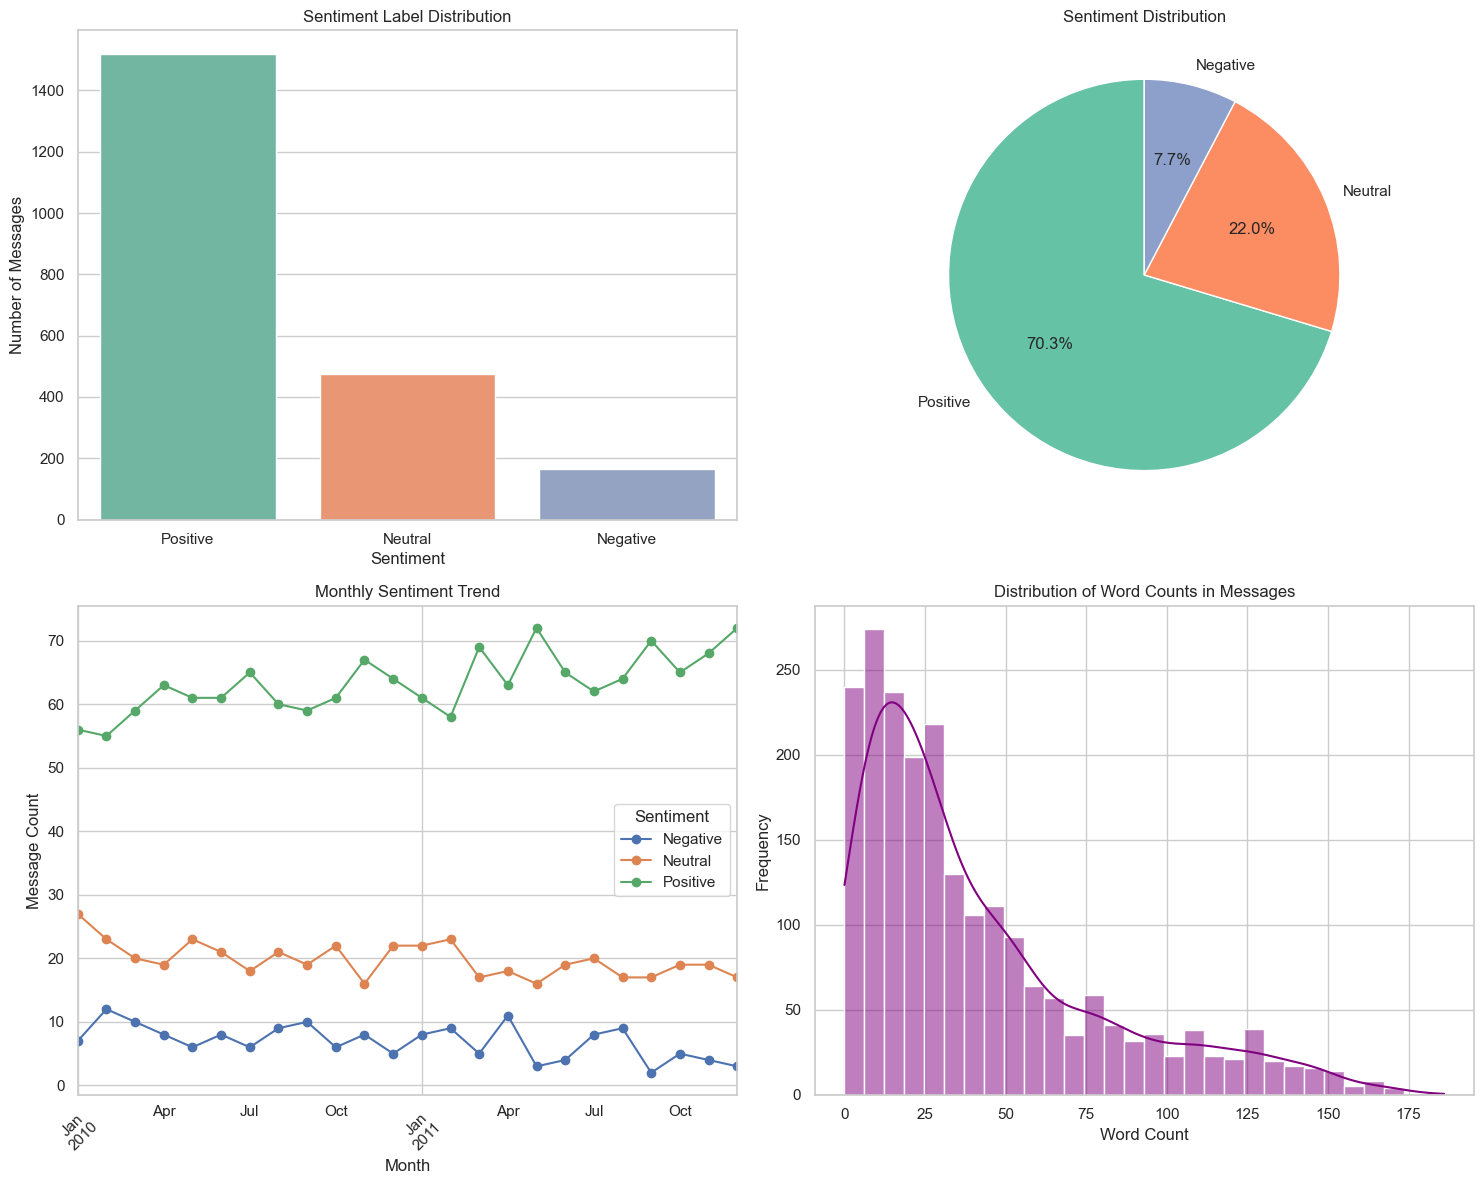

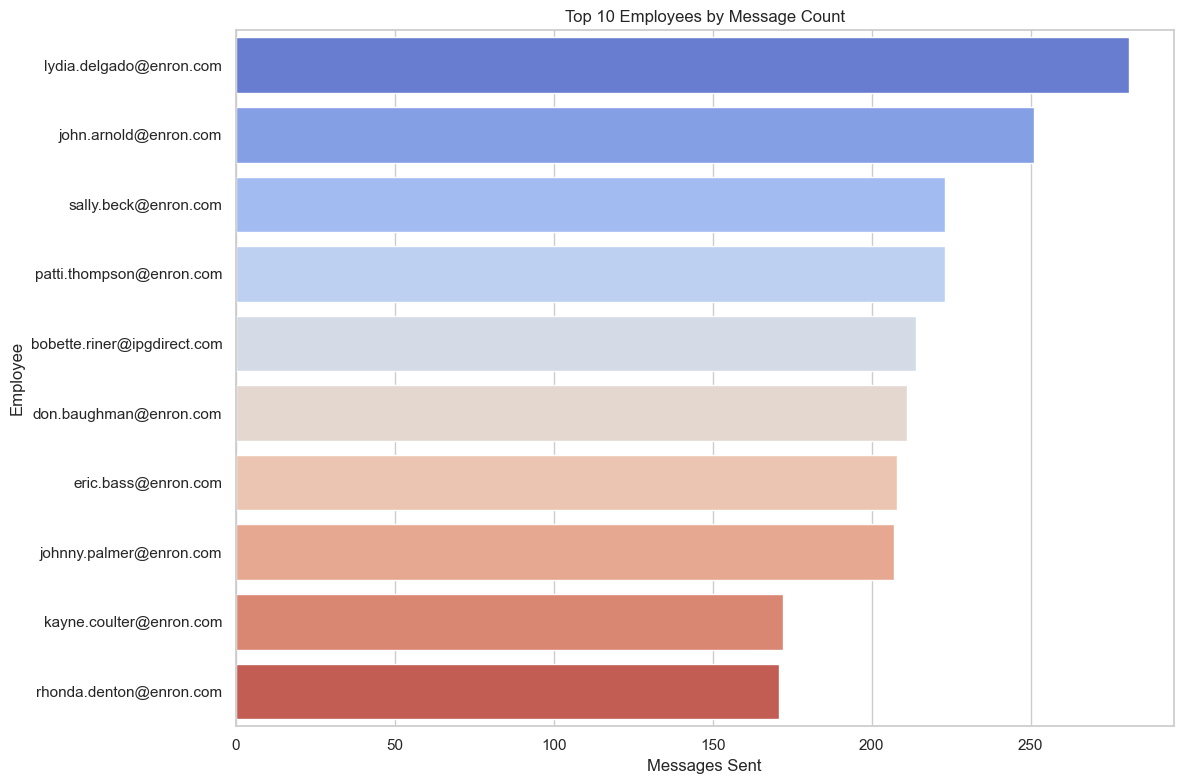

EDA completed and visualizations saved!

TASK 3: EMPLOYEE SCORE CALCULATION
Monthly scores calculated for 239 employee-month combinations
Score range: -1 to 20
Monthly scores saved to 'monthly_employee_sentiment_scores.xlsx'

TASK 4: EMPLOYEE RANKING
Top 3 Positive and Negative Employees per Month:
                       employee    month  monthly_sentiment_score  \
72  bobette.riner@ipgdirect.com  2010-01                        1   
73      johnny.palmer@enron.com  2010-01                        1   
74      rhonda.denton@enron.com  2010-01                        1   
0       kayne.coulter@enron.com  2010-01                       11   
1           eric.bass@enron.com  2010-01                        9   
2       lydia.delgado@enron.com  2010-01                        9   
76      lydia.delgado@enron.com  2010-02                        1   
77     patti.thompson@enron.com  2010-02                        1   
75      kayne.coulter@enron.com  2010-02                       -1   
3         

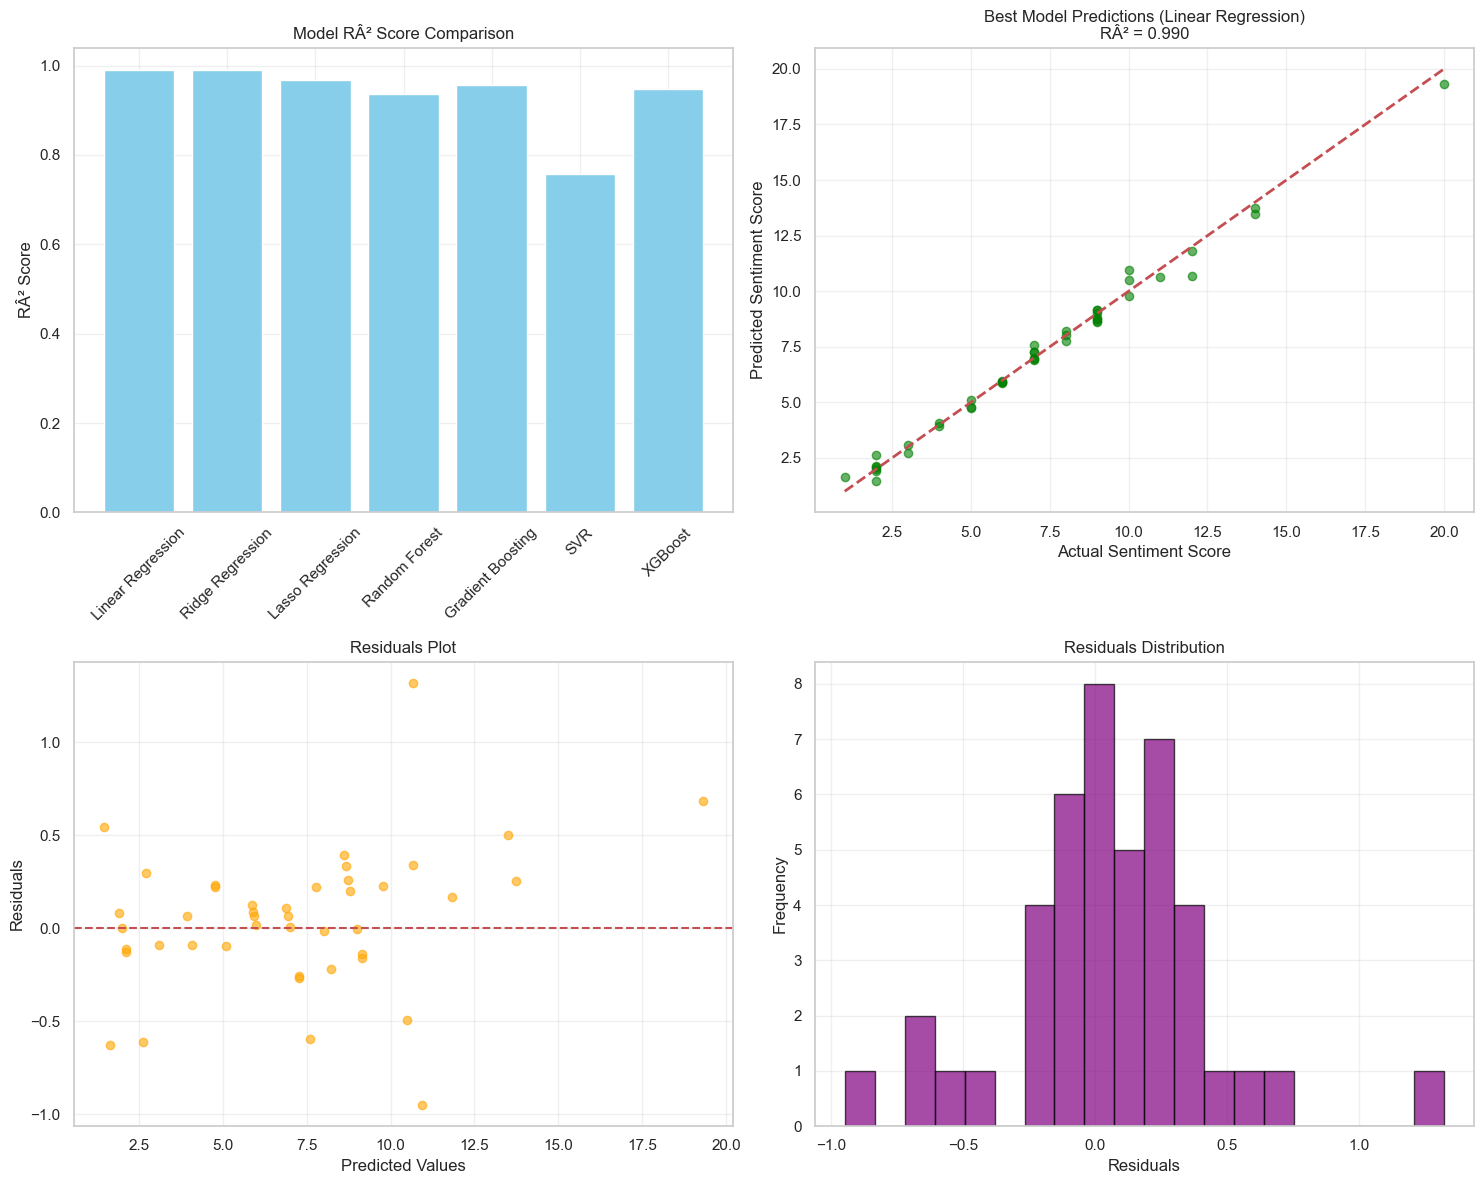


Cross-validation RÂ² scores: [0.97057616 0.97947045 0.98666335 0.98491774 0.98003194]
Mean CV RÂ²: 0.980 (+/- 0.011)

CREATING SUMMARY REPORT
Overall Top 3 Positive Employees:
1. lydia.delgado@enron.com (Score: 7.6)
2. john.arnold@enron.com (Score: 7.3)
3. patti.thompson@enron.com (Score: 6.2)

Overall Top 3 Negative Employees:
1. bobette.riner@ipgdirect.com (Score: 4.9)
2. rhonda.denton@enron.com (Score: 4.6)
3. kayne.coulter@enron.com (Score: 4.0)

Flight Risk Employees (4 total):
- kayne.coulter@enron.com
- sally.beck@enron.com
- bobette.riner@ipgdirect.com
- patti.thompson@enron.com

Model Performance: RÂ² = 0.990

PROJECT COMPLETED SUCCESSFULLY!
All tasks completed according to project requirements:
 Task 1: Sentiment Labeling
 Task 2: Exploratory Data Analysis
 Task 3: Employee Score Calculation
 Task 4: Employee Ranking
 Task 5: Flight Risk Identification (CORRECTED)
 Task 6: Predictive Modeling
 Documentation and Visualizations


In [16]:
#main function
if __name__ == "__main__":
    main() 